# *Library*

In [ ]:
!pip install -U finance-datareader

In [ ]:
import FinanceDataReader as fdr

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
import torch.nn as nn

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# *Data* *setup*

In [ ]:
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [ ]:
df_krx[df_krx['Name'].str.contains('카카오')]

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
302,58GD32,KOSPI,KBGD32카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
338,58GE31,KOSPI,KBGE31카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
425,58GF51,KOSPI,KBGF51카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
426,58GF52,KOSPI,KBGF52카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
427,58GF53,KOSPI,KBGF53카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6654,57GY02,KOSPI,한국GY02카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6655,57GY03,KOSPI,한국GY03카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6785,57GZ33,KOSPI,한국GZ33카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6786,57GZ34,KOSPI,한국GZ34카카오콜,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [ ]:
df_krx.drop(df_krx[df_krx['Sector'].isnull()].index, inplace=True, axis=0)
df_krx.isnull().sum()

Symbol              0
Market              0
Name                0
Sector              0
Industry           19
ListingDate         0
SettleMonth         0
Representative      0
HomePage          148
Region              0
dtype: int64

In [ ]:
df_krx[df_krx['Name'].str.contains('카카오')]

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
5257,035720,KOSPI,카카오,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업",인터넷 서비스(인터넷 광고),2017-07-10,12월,"여민수, 조수용",http://www.kakaocorp.com,제주특별자치도
5258,293490,KOSDAQ,카카오게임즈,소프트웨어 개발 및 공급업,"모바일, PC게임 퍼블리싱",2020-09-10,12월,"남궁훈, 조계현",http://kakaogames.com,경기도
5259,323410,KOSPI,카카오뱅크,은행 및 저축기관,은행 및 금융서비스,2021-08-06,12월,윤호영,NaN,경기도
5260,377300,KOSPI,카카오페이,금융 지원 서비스업,"간편결제, 간편송금 및 기타 금융서비스",2021-11-03,12월,류영준,http://www.kakaopay.com,경기도


findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans.


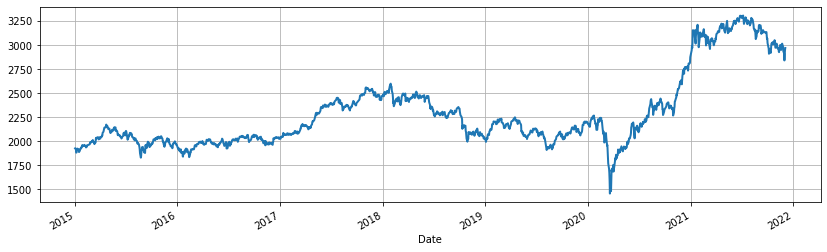

In [ ]:
kospi_short = fdr.DataReader('KS11','2015')
kospi_total = fdr.DataReader('KS11')
kospi_short['Close'].plot()

In [ ]:
kospi_short.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2015-01-02,1926.44,1914.24,1929.15,1909.67,258780000.0,0.0057
2015-01-05,1915.75,1921.96,1921.96,1903.37,313440000.0,-0.0055
2015-01-06,1882.45,1895.48,1900.02,1877.38,303690000.0,-0.0174
2015-01-07,1883.83,1878.90,1887.60,1876.27,280510000.0,0.0007
2015-01-08,1904.65,1895.85,1907.23,1891.77,262210000.0,0.0111


In [ ]:
df = kospi_short.reset_index()
df.groupby([df['Date'].dt.year, df['Date'].dt.month]).mean()

Close         Open  ...        Volume        Change
Date Date                            ...                            
2015 1     1920.992857  1920.563810  ...  3.259910e+08  8.571429e-04
     2     1961.001176  1962.690000  ...  3.478435e+08  1.094118e-03
     3     2012.619091  2013.155000  ...  3.869005e+08  1.268182e-03
     4     2107.268182  2107.546818  ...  5.264936e+08  1.900000e-03
     5     2114.898889  2118.251667  ...  4.104889e+08 -2.944444e-04
...                ...          ...  ...           ...           ...
2021 8     3182.500952  3186.790476  ...  6.571862e+08  8.260588e-19
     9     3141.699474  3144.794737  ...  7.510274e+08 -2.168421e-03
     10    2989.873158  3001.907895  ...  7.321968e+08 -1.663158e-03
     11    2964.301818  2974.732727  ...  6.267755e+08 -2.018182e-03
     12    2937.773333  2890.230000  ...  5.283800e+08  1.496667e-02

[84 rows x 6 columns]

# *Hyperparameter setting*

In [ ]:
# hyper-parameter setting
num_sample = 16
epochs = 1000
learning_rate = 0.001
time_step = 84

hidden_dim = 512
output_dim = 12
input_dim = time_step - output_dim

# input_columns is number of input dataframe's columns
input_columns = 1

# *Functions*

In [ ]:
# make a date chart as a month chart
# Data starts from 2015y, so sequence length will be different when you run this
def month_mean(symbol):
    df = fdr.DataReader(symbol, '2015').reset_index()
    df.drop(['Open', 'High', 'Low', 'Volume', 'Change'], axis=1, inplace=True)
    df = df.groupby([df['Date'].dt.year, df['Date'].dt.month]).mean()
    df.reset_index(drop=True, inplace=True)
    if len(df) < time_step:
        pad_len = time_step - len(df)
        pad = np.zeros((pad_len, 1))
        df = np.concatenate((pad, df), axis=0)
    return df

# make dateframe as input tensor and target tensor
def toTensor(df):
    tensor = torch.FloatTensor([df]).to(device)
    # (batch_size, sequence_length, input_size)
    # (num_sample, time step, num of columns)
    # (train_dataset), (valid_dataset) (test_dataset)
    # (16, 72, 1), (16, 72, 1) (16, 12, 1)
    return tensor[:,:-output_dim,:], tensor[:,1:-output_dim + 1,:], tensor[:,-output_dim:,:]


# *Model*

In [ ]:
# define a model
class LSTM(nn.Module):
    def __init__(self, input_columns, hidden_dim, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_columns, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # input x has (16, 72, 5)
        x, _status = self.lstm(x)
        x = self.fc(x)
        return x

model = LSTM(input_columns, hidden_dim, 1).to(device)

# *Criterion*

In [ ]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# *Train and validation*

In [ ]:
def train_one_epoch(input_tensor,val_tensor, model):
    loss = 0.0
    optimizer.zero_grad()
    
    output = model(input_tensor).to(device)
    loss = criterion(output.view(-1), val_tensor.view(-1)).to(device)

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_tensor.size(0)

In [ ]:
def validation(start_from):
    with torch.no_grad():
        output = torch.zeros((num_sample, output_dim, 1)).to(device)
        for i in range(output_dim):
            output[:,i:i+1,:] = model(start_from).to(device)
            start_from = output[:, i:i+1, :]
        return output
        

In [ ]:
def train_iter(model, epochs):
    import time
    import math

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return "%dm %ds" % (m, s)

    print_every = 100
    all_losses = []
    total_loss = 0

    start = time.time()
    random_symbol = df_krx['Symbol'].sample(n=num_sample)
    random_symbol.reset_index(drop=True, inplace=True)

    df = month_mean(random_symbol[0])
    ss = StandardScaler()
    df = ss.fit_transform(df)
    input_tensor, valid_tensor, target_tensor = toTensor(df)
    for i in range(1, num_sample):
        df = month_mean(random_symbol[i])
        df = normalization(df)
        input_tensor_temp, valid_tensor_temp, target_tensor_temp = toTensor(df)
        input_tensor = torch.cat((input_tensor, input_tensor_temp), 0)
        valid_tensor = torch.cat((valid_tensor, valid_tensor_temp), 0)
        target_tensor = torch.cat((target_tensor, target_tensor_temp), 0)

    for epoch in range(1, epochs+1):
        output_tensor, loss = train_one_epoch(input_tensor, valid_tensor, model)
        total_loss += loss

        if epoch % print_every == 0:
            print('%s (epoch : %d, %d%%) loss : %.4f' % (timeSince(start), epoch, epoch/epochs*100, total_loss / print_every))
            all_losses.append(total_loss/print_every)
            total_loss = 0

    plt.figure(figsize=(8, 6))
    plt.title('Loss')
    plt.plot(all_losses)

    val = validation(output_tensor[:, -1:, :])
    for n in range(num_sample):
        output = torch.cat((output_tensor[n, :, :], val[n, :, :]), 0)
        target = torch.cat((input_tensor[n, :, :],target_tensor[n, :, :]), 0)
        output = ss.inverse_transform(output.detach().to('cpu'))
        target = ss.inverse_transform(target.detach().to('cpu'))

        plt.figure(figsize=(10, 6))
        plt.axvline(x=72, c='r', linestyle='--')
        plt.plot(target, label='actual data')
        plt.plot(output, label='trained data')
        plt.legend()
        plt.show()


# *Main*

0m 19s (epoch : 100, 10%) loss : 0.0037
0m 22s (epoch : 200, 20%) loss : 0.0010
0m 25s (epoch : 300, 30%) loss : 0.0003
0m 28s (epoch : 400, 40%) loss : 0.0002
0m 31s (epoch : 500, 50%) loss : 0.0002
0m 34s (epoch : 600, 60%) loss : 0.0001
0m 36s (epoch : 700, 70%) loss : 0.0002
0m 39s (epoch : 800, 80%) loss : 0.0002
0m 42s (epoch : 900, 90%) loss : 0.0001
0m 45s (epoch : 1000, 100%) loss : 0.0001


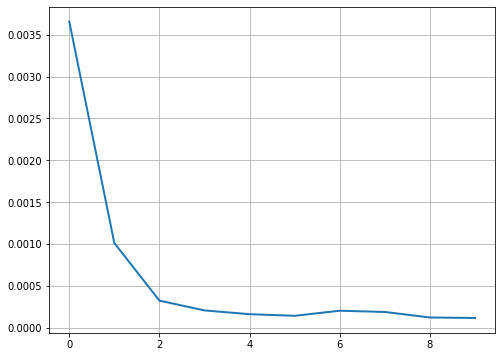

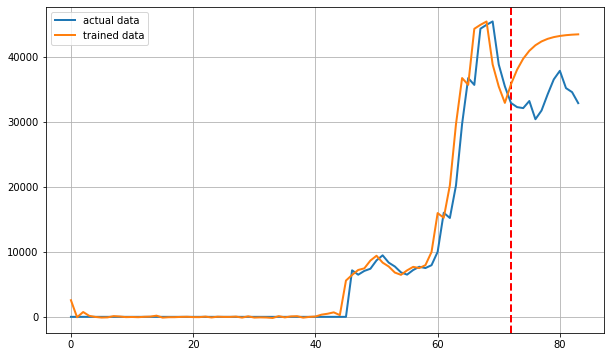

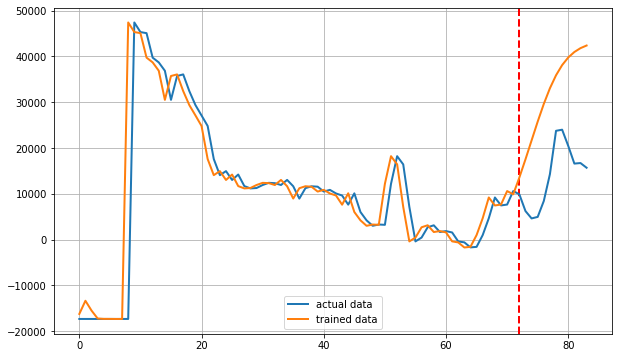

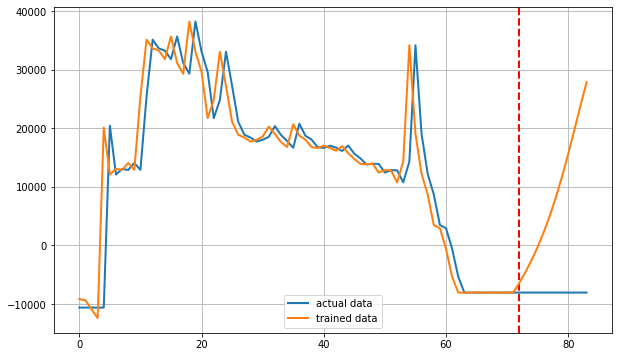

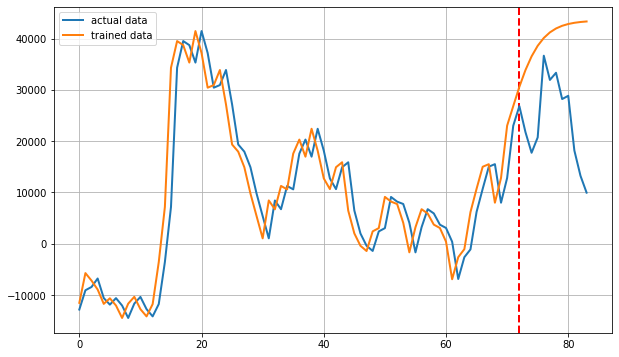

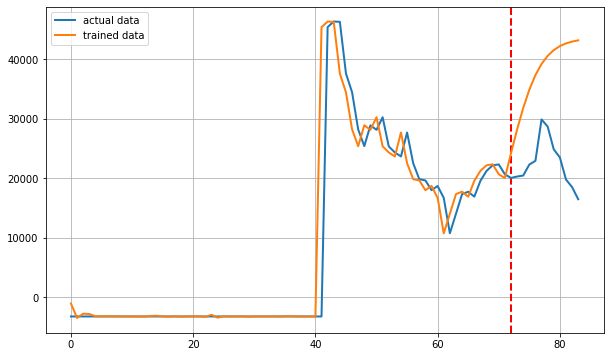

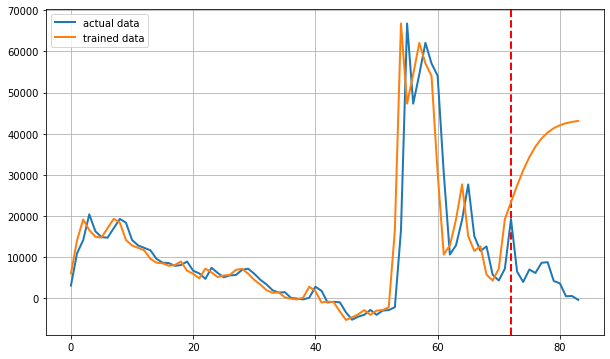

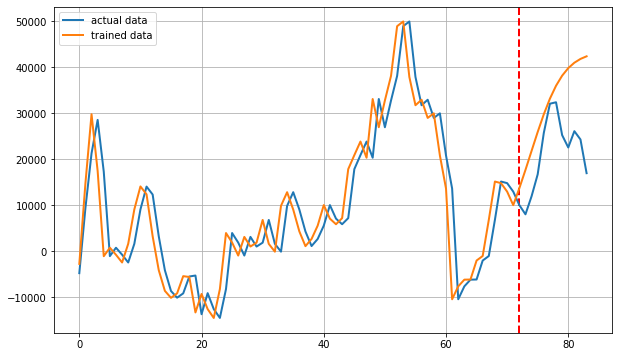

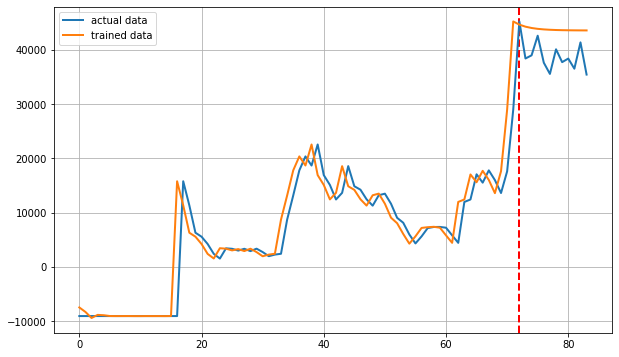

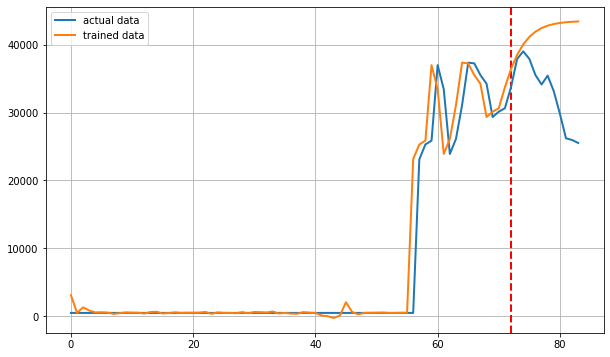

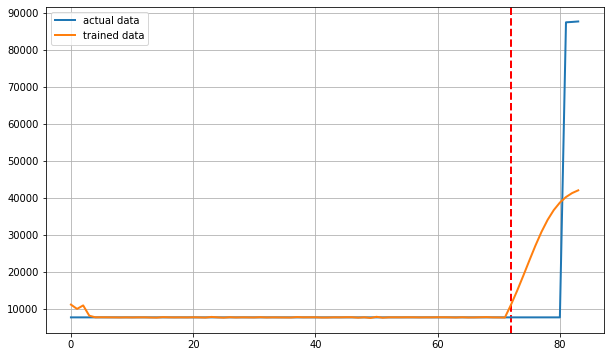

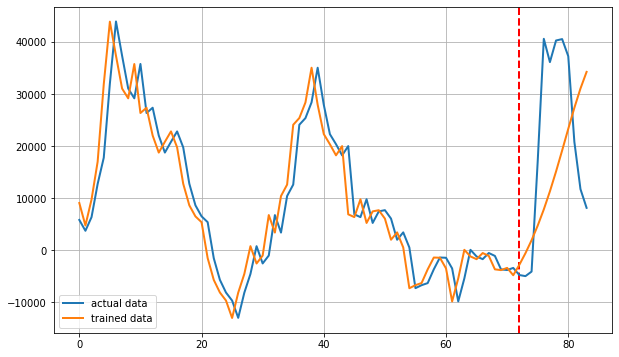

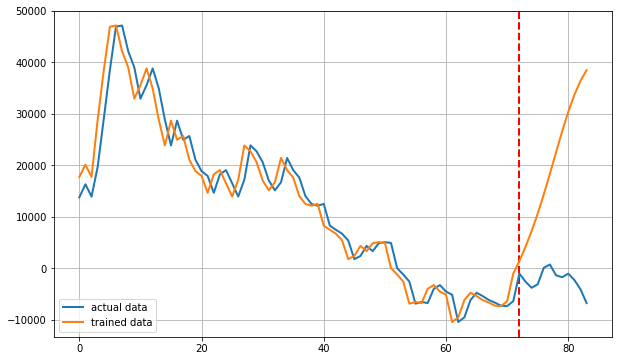

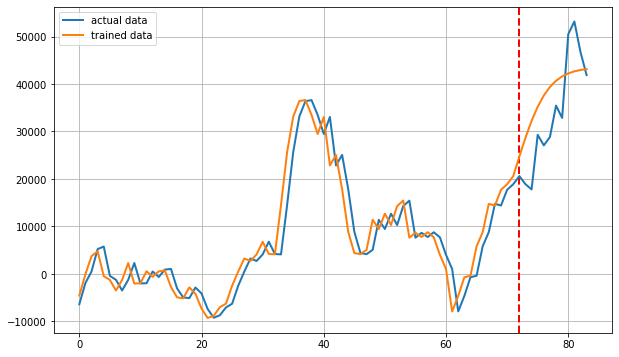

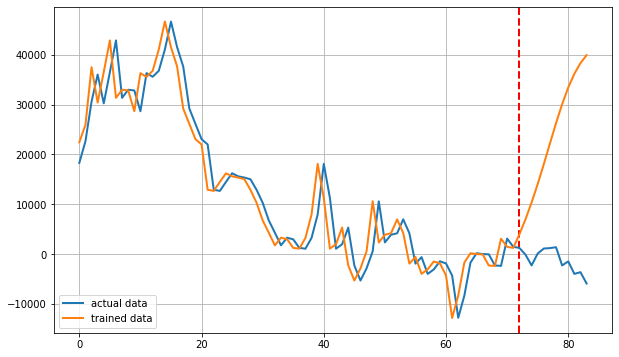

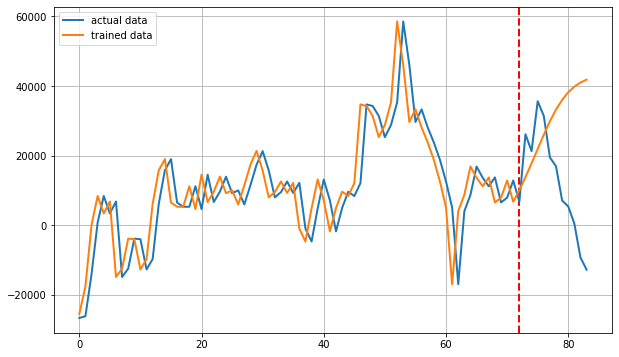

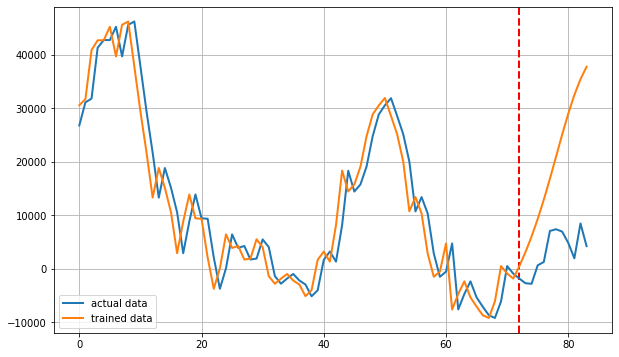

In [ ]:
train_iter(model, epochs)